### Load the liabrary

### Load the liabrary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

### Load data

In [63]:
df = pd.read_csv("/kaggle/input/laptop-final-data/laptop_final.csv")
print(df.head(5))
print(df.columns)

                                                link  \
0  https://laptopmedia.com/laptop-specs/asus-rog-...   
1  https://laptopmedia.com/laptop-specs/asus-rog-...   
2  https://laptopmedia.com/laptop-specs/asus-rog-...   
3  https://laptopmedia.com/laptop-specs/asus-rog-...   
4  https://laptopmedia.com/laptop-specs/asus-rog-...   

                       name  Display Size  Resolution: width  \
0        ASUS ROG Strix G17          17.3             2560.0   
1  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
2  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
3  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
4        ASUS ROG Strix G17          17.3             2560.0   

   Resolution: height  Refresh Rate       Panel Type  Disk Capacity  SSD  HDD  \
0              1440.0         240.0     IPS + G-Sync         2000.0  1.0  0.0   
1              1600.0         240.0   IPS + FreeSync        16000.0  1.0  0.0   
2              1600.0         240.0

In [4]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df2= df.drop(columns=["link","name","Total Score","Work Score","Portability Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df2 = df2.drop_duplicates()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


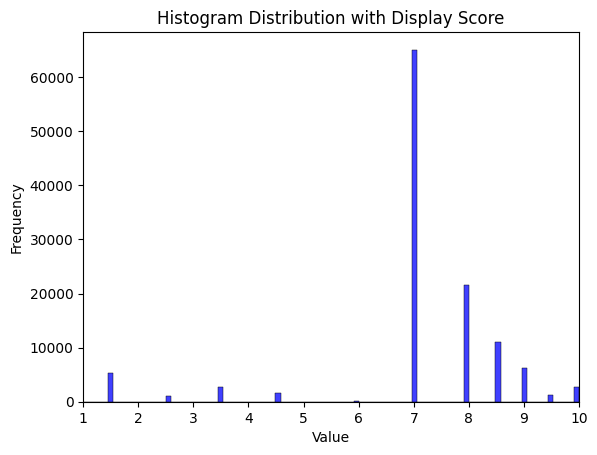

In [5]:
# play score distribution 
sns.histplot(df2['Display Score'], bins=100, color='blue')

plt.title("Histogram Distribution with Display Score")
plt.xlabel("Value")
plt.xlim(1,10)
plt.ylabel("Frequency")

plt.show()

### Drop nan values

In [6]:
df2.isnull().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 256
RAM Type                                   26332
OS                                           659
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [7]:
df2 = df.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is:{} and after drop nan values is:{}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is:289171 and after drop nan values is:162759


### Add more features following our knowledge about laptop architecture

*  Add more features following our knowledge about laptop architecture

In [8]:
# Add the aspect ratio for each laptop, equals (width/ height)
df2['Aspect Ratio'] = df2['Resolution: width'] / df2['Resolution: height']
# Add the pixel density for each laptop, equals sqrt(width^2 + height ^2) / display size
df2['Pixel Density'] = ((df2['Resolution: width']**2 + df2['Resolution: height']**2)**0.5) / df2['Display Size']
# Add the gpu performance for each laptop, equals memory size * memory frequency.
df2['GPU Performance'] = df2['GPU: Memory Size'] * df2['GPU: Memory Frequency (MHz)']

/tmp/ipykernel_24/2442813279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Aspect Ratio'] = df2['Resolution: width'] / df2['Resolution: height']
/tmp/ipykernel_24/2442813279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Pixel Density'] = ((df2['Resolution: width']**2 + df2['Resolution: height']**2)**0.5) / df2['Display Size']
/tmp/ipykernel_24/2442813279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

### Train Test split

In [9]:
target="Display Score"
X=df2.drop(columns=[target])
y=df2[target]

In [10]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

* Encode categorical columns using target encoding

In [11]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df2[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [12]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train) 
X_test=encoder.transform(X_test) 

### Features Selection

In [13]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]+[
                        "Aspect Ratio","Pixel Density","GPU Performance"
                    ]            
categorical_features=list(set(df2.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['SSD', 'Body material: plastic / polycarbonate', 'OS', 'Security Lock slot', 'Card Reader', 'Body material: glass fiber', 'Body material: carbon', 'Optane', 'Body material: magnesium alloy', 'GPU: Memory Type', 'Backlit keyboard', 'Body material: aluminum', 'Fingerprint reader', 'RAM Type', 'SSHD', 'Body material: matte', 'Body material: black synthetic material', 'Panel Type', 'Body material: magnesium-lithium alloy', 'GPU: Architecture', 'Body material: plastic', 'HDD']
22


* Normalize for features selection

In [14]:
normalized_X_train = X_train.copy() 
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train 

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,Aspect Ratio,Pixel Density,GPU Performance
40797,-0.166023,-0.284905,-0.337344,0.526531,7.415565,0.000339,1.0,0.0,0.0,0.0,...,7.444707,2.932949,1.117836,1.273688,0.372876,2.375809,0.304534,0.422981,-0.262666,2.377865
93460,-0.166023,-0.284905,-0.337344,0.526531,7.415565,0.000339,1.0,0.0,0.0,0.0,...,7.444707,-0.210544,0.113764,0.793642,0.372876,0.457842,0.304534,0.422981,-0.262666,-0.288258
135678,-1.684292,-0.284905,0.089227,-0.712992,7.415565,0.000339,1.0,0.0,0.0,0.0,...,6.509786,-0.535733,-0.890308,-0.991047,-0.973642,-0.364144,-0.939078,-2.249552,0.340271,-0.419379
196558,-0.166023,-0.284905,-0.337344,-0.712992,7.415565,-0.392231,1.0,0.0,0.0,0.0,...,6.509786,-0.535733,-0.890308,-0.991047,-0.973642,-0.364144,-0.939078,0.422981,-0.262666,-0.419379
201973,-1.684292,-0.284905,-0.337344,-0.712992,7.415565,-0.684304,1.0,0.0,0.0,0.0,...,6.509786,-0.535733,-0.890308,-0.991047,-0.973642,-0.364144,-0.939078,0.422981,0.211683,-0.419379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246764,0.213544,1.166208,1.511131,0.836412,7.849661,0.785479,1.0,0.0,0.0,0.0,...,7.444707,-0.156346,0.615800,1.113028,1.046134,0.183847,1.237244,-2.249552,1.132518,-0.189918
214150,1.447137,-1.010461,-0.977201,-0.712992,2.261094,0.000339,1.0,0.0,0.0,0.0,...,6.509786,-0.535733,-0.890308,-0.991047,-0.973642,-0.364144,-0.939078,0.422981,-1.294305,-0.419379
33431,0.213544,1.166208,1.511131,0.836412,7.849661,0.000339,1.0,0.0,0.0,0.0,...,7.444707,-0.156346,1.117836,0.199391,1.719393,1.279828,1.859050,-2.249552,1.132518,-0.113431
47087,-0.166023,-0.284905,-0.337344,0.526531,7.447350,-0.583806,1.0,0.0,0.0,0.0,...,7.444707,-0.156346,0.615800,0.170356,1.046134,0.183847,0.719072,0.422981,-0.262666,-0.189918


* Using mutual info and anova to find the most relevant categorical features

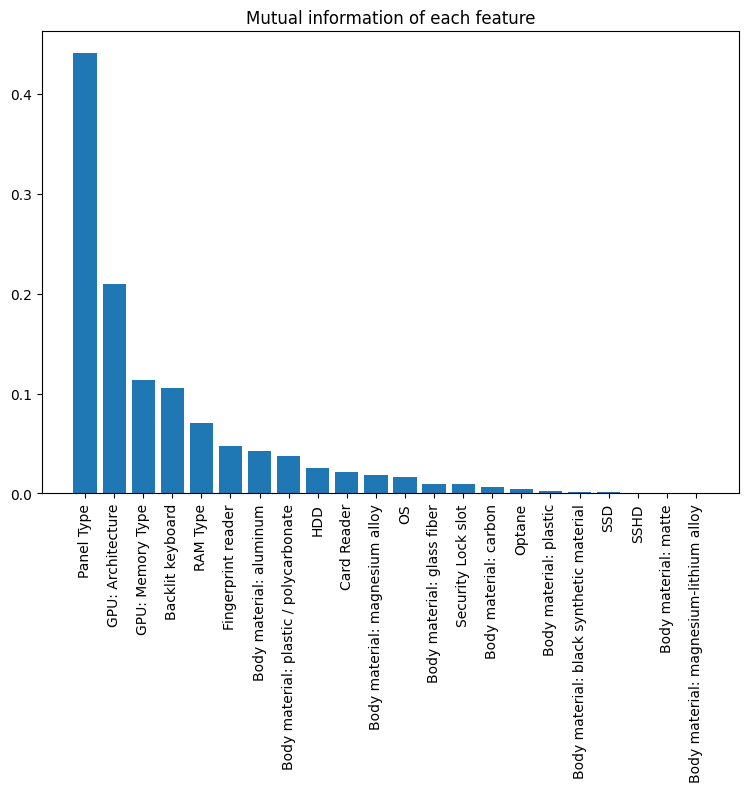

In [15]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 16 20] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


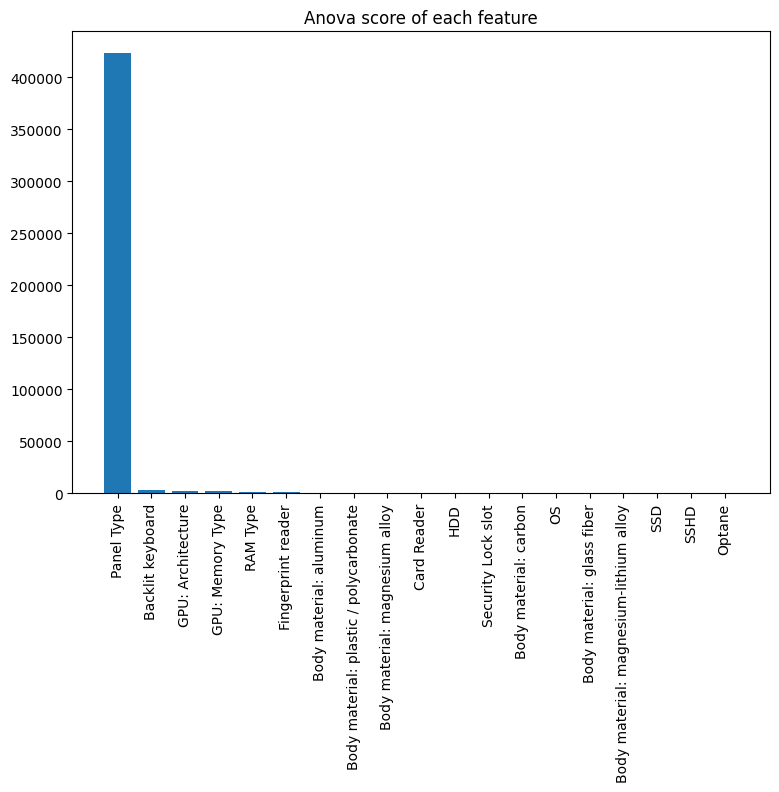

In [16]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

* Using pearson correlation, spearman to find the most relevant in numerical features

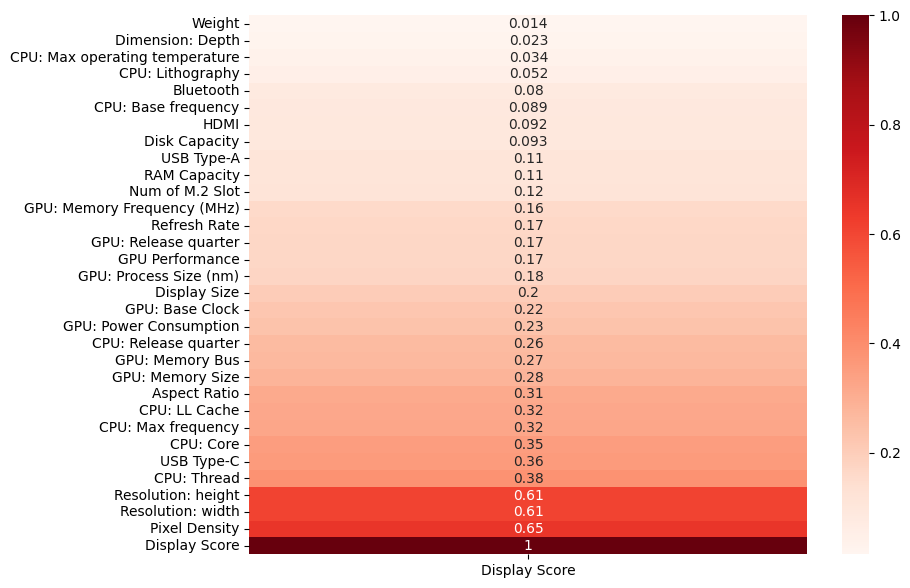

In [17]:
# using pearsonscore
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

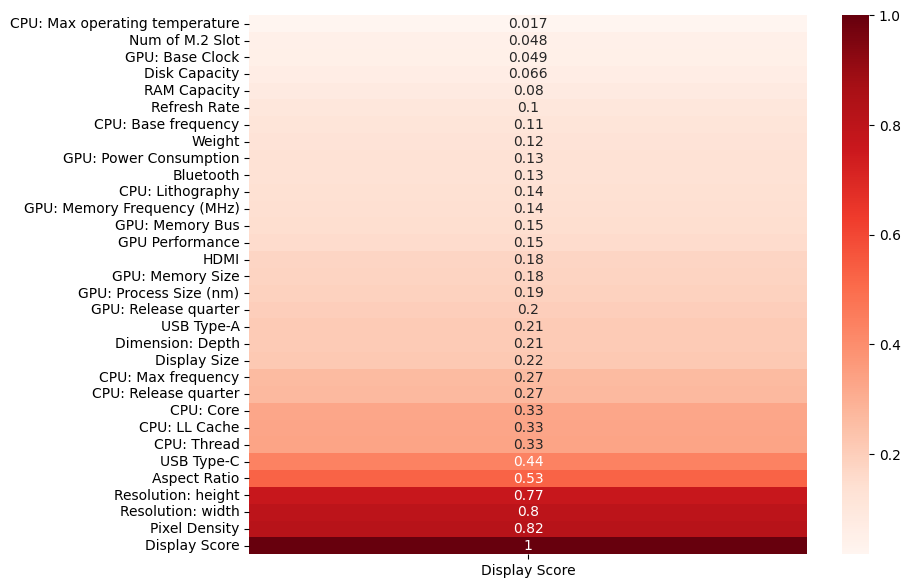

In [18]:
# using spearman score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

* Using Random Forest to choose important features in 2 groups

In [19]:
# Choose candidate features in 2 groups
candidate_num_features = target_correlation[target].abs().sort_values(ascending=False).index[1:6].tolist()
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['Panel Type', 'GPU: Architecture', 'GPU: Memory Type', 'Backlit keyboard', 'RAM Type', 'Pixel Density', 'Resolution: width', 'Resolution: height', 'Aspect Ratio', 'USB Type-C']


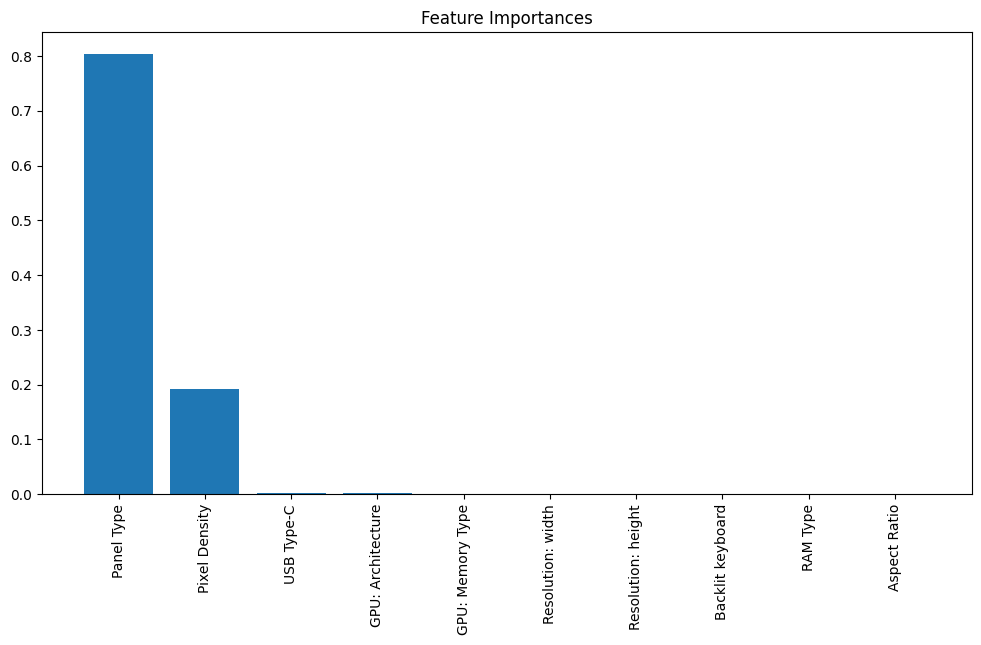

In [20]:
candidate_X = X_train[candidate_featues]
model = RandomForestRegressor()
model.fit(candidate_X, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [21]:
#Choose importatn features based on the importance score in RF
final_features = ["Panel Type","Pixel Density"]

### Remove Outlier

In [22]:
choosen_num_features = "Pixel Density"
choosen_cat_features = "Panel Type"

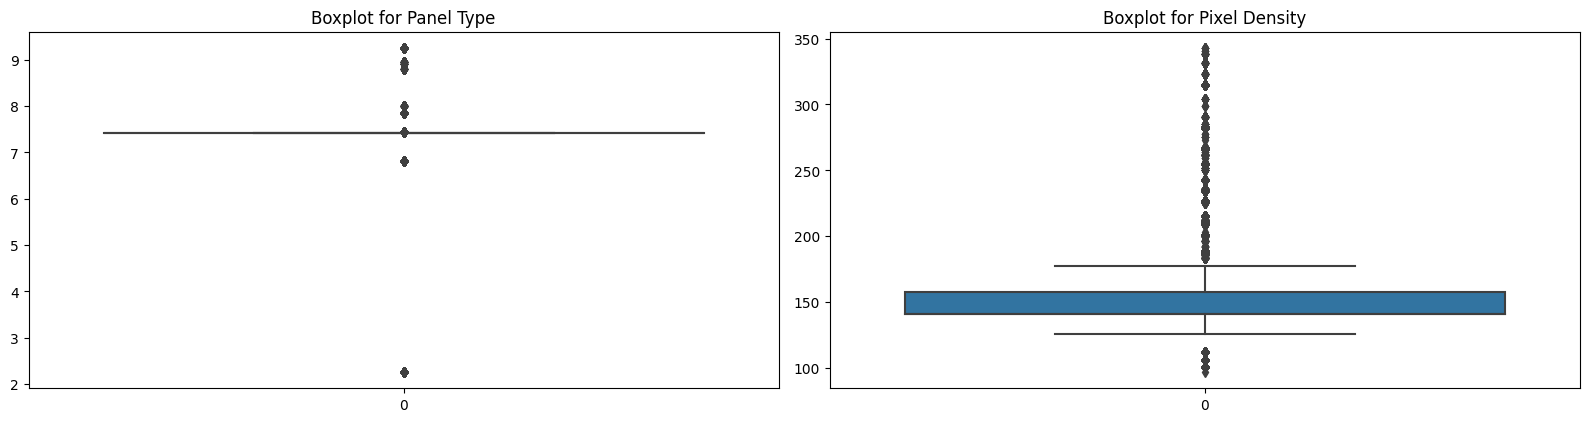

In [23]:
plt.figure(figsize=(16,12))
for i,var in enumerate(final_features):
  plt.subplot(3,2,i+1)
  sns.boxplot(X_train[var])
  plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

* Numerical features

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Pixel Density', ylabel='Count'>

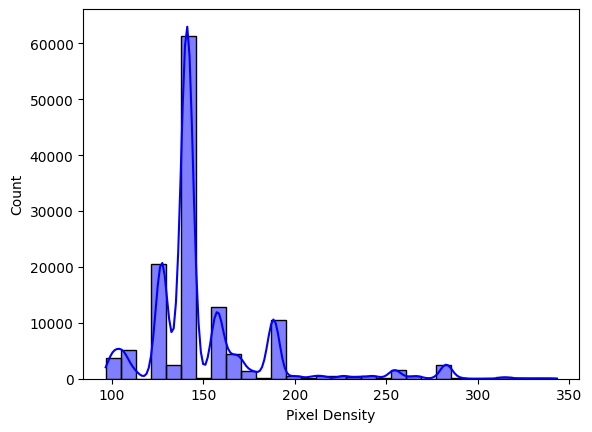

In [24]:
sns.histplot(X_train[choosen_num_features], kde=True, bins=30, color='blue')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


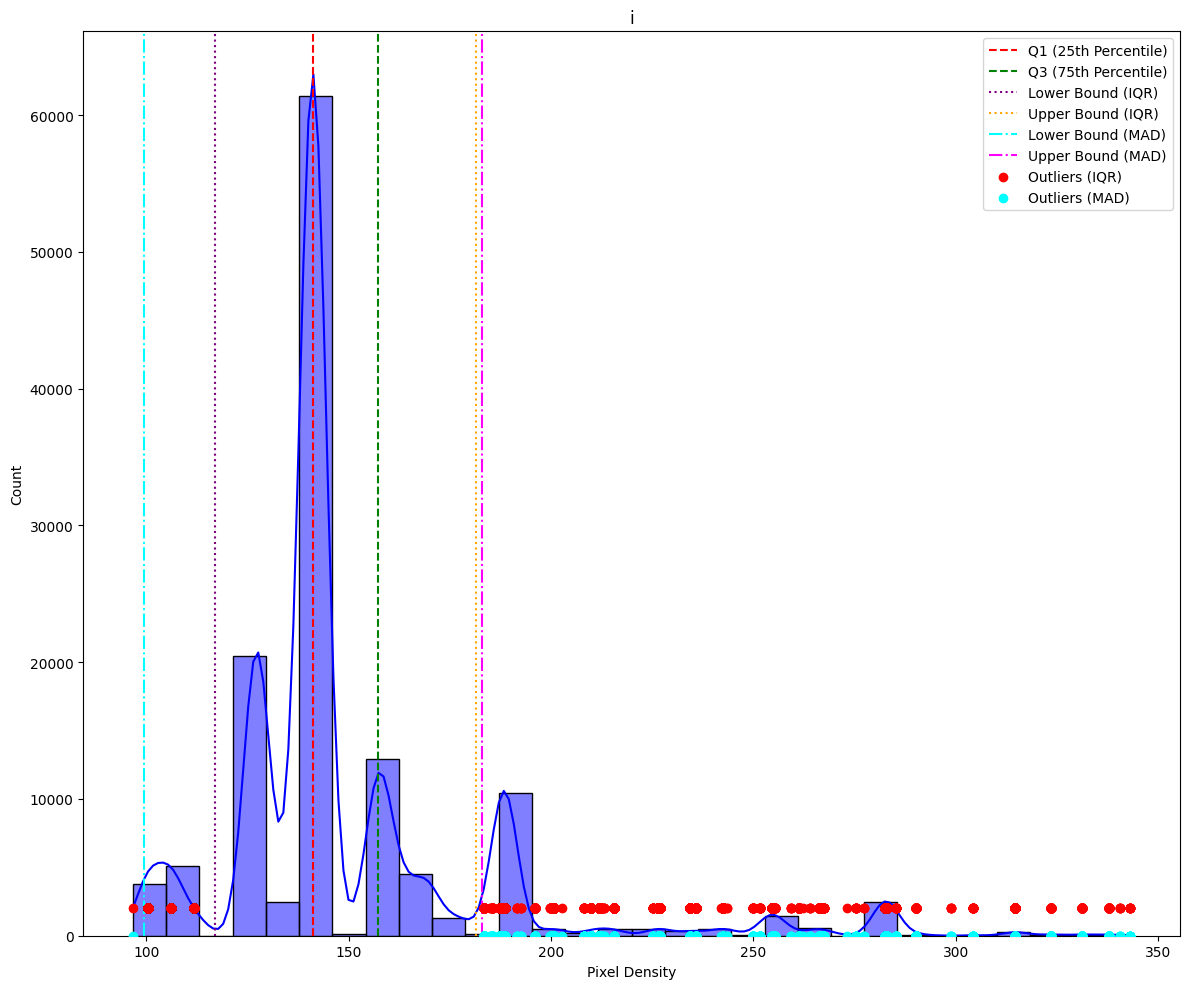

In [25]:
# Suppose the removal of outlier based on IQR and MAD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=30, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
fig, axes = plt.subplots(figsize=(12, 10))
plot_distribution(X_train[choosen_num_features], axes, choosen_num_features[i])
plt.tight_layout()
plt.show()


In [26]:
Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[choosen_num_features])
outliers_iqr = X_train[(X_train[choosen_num_features] < lower_bound_iqr) | (X_train[choosen_num_features]> upper_bound_iqr)]
print("Number of outlier based on IQR technique in feature "+ choosen_num_features+": "+"{}".format(len(outliers_iqr)))
outliers_mad = X_train[(X_train[choosen_num_features] < lower_bound_mad) | (X_train[choosen_num_features]> upper_bound_mad)]
print("Number of outlier based on MAD technique in feature "+ choosen_num_features+": "+"{}".format(len(outliers_mad)))

Number of outlier based on IQR technique in feature Pixel Density: 27064
Number of outlier based on MAD technique in feature Pixel Density: 18208


* Categorical features

In [27]:
threshold_percentage = 1 # put threshold percentage of 1 %

freq = X_train[choosen_cat_features].value_counts(normalize=True) * 100  
rare_categories = freq[freq < threshold_percentage].index.tolist()
num_outlier = X_train[choosen_cat_features].isin(rare_categories).sum()
print(choosen_cat_features + ": "+ str(num_outlier))
reduced_X_train = X_train[~X_train[choosen_cat_features].isin(rare_categories)] 


Panel Type: 648


In [28]:
print(reduced_X_train.shape[0])

129559


In [34]:
reduced_X_train = reduced_X_train.drop_duplicates()

In [35]:
reduced_y_train = y_train[reduced_X_train.index] 

In [36]:
print(reduced_X_train.shape)

(67756, 53)


* Plot the relationship between the features and the target

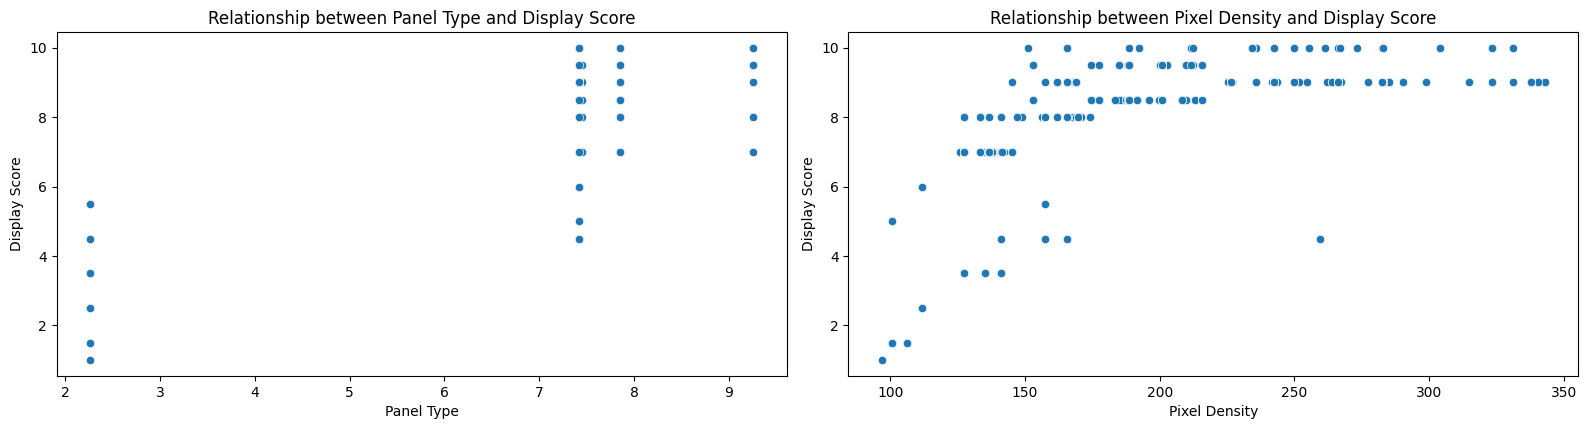

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
for i,var in enumerate(final_features):
  plt.subplot(3,2,i+1)
  sns.scatterplot(x=reduced_X_train[var], y=reduced_y_train)
  plt.title(f'Relationship between {var} and Display Score')
plt.tight_layout()
plt.show()

### Fine-tuning hyperparameters

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

* Model

In [38]:
model = {'K-Nearest Neighbors': KNeighborsRegressor(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regresion': SVR(),
    'Gradient Boosting' : GradientBoostingRegressor()}

* Grid Search

In [39]:
def grid_search(X, y,X_test, y_test, model , param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X, y)

    # result
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X)
    print("Best parameters:", grid_search.best_params_)
    print("Best Score Train (MAE): ", mean_absolute_error(y_pred_train,y))
    print("Best Score Train (RMSE): ", np.sqrt(mean_squared_error(y_pred_train,y)))
    # evaluation
    print("\n --- Inference on Test Set ---")

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print('\n')

* Data Transform

In [40]:
scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(reduced_X_train[final_features])
X_normalized_test = scaler.transform(X_test[final_features])

In [41]:
y_train_final = reduced_y_train

* KNN

In [60]:
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9,12],        
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'minkowski']} 
grid_search(X_normalized_train,y_train_final,X_normalized_test, y_test, model['K-Nearest Neighbors'],param_grid_KNN)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Best Score Train (MAE):  0.07118369180917146
Best Score Train (RMSE):  0.24868196841263646

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 0.31216583623396515
Mean Absolute Error (MAE): 0.07495565460590985




* Ridge Regression

In [59]:
param_grid_ridge = {
    'alpha': [0.1,0.001, 0.2,1, 10, 20],
    'solver': ['auto', 'sag', 'lsqr'],
    'fit_intercept': [True, False],
}
grid_search(X_normalized_train,y_train_final,X_normalized_test, y_test, model['Ridge Regression'],param_grid_ridge)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'alpha': 10, 'fit_intercept': True, 'solver': 'sag'}
Best Score Train (MAE):  0.3663125763702011
Best Score Train (RMSE):  0.49581807354345037

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 0.5342143651890062
Mean Absolute Error (MAE): 0.3725549255052719




* Random Forest

In [61]:
param_grid_rf = {
    'n_estimators': [50, 100, 200,300,350],
    'max_depth': [10,20,25],
    'min_samples_split': [2],
    'max_features': ['sqrt', 'log2'],
}
grid_search(X_normalized_train, y_train_final,X_normalized_test, y_test, model['Random Forest'],param_grid_rf)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best Score Train (MAE):  0.1131537379030414
Best Score Train (RMSE):  0.23773517167497202

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 0.30682663406718913
Mean Absolute Error (MAE): 0.11858443670712969




* Support Vector regresion

In [42]:
param_grid_svm = {
    'C': [10, 100, 120],             
    'epsilon': [0.1, 0.2, 0.3],    
    'kernel': ['rbf'], 
}
grid_search(X_normalized_train, y_train_final,X_normalized_test, y_test, model['Support Vector Regresion'],param_grid_svm)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 120, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score Train (MAE):  0.15319327127965401
Best Score Train (RMSE):  0.265534482938848

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 0.33745767809562077
Mean Absolute Error (MAE): 0.16081050745830272




Gradient Boosting Regression

In [46]:
param_grid_gradient = {
    'n_estimators': [50, 100 , 120 , 150, 160, 170],        
    'learning_rate': [0.03, 0.05],    
    'max_depth': [3, 5, 7, 8],                          
}
grid_search(X_normalized_train, y_train_final,X_normalized_test, y_test, model['Gradient Boosting'],param_grid_gradient)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 170}
Best Score Train (MAE):  0.11325121974129243
Best Score Train (RMSE):  0.23771970018540955

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 0.3068944103819504
Mean Absolute Error (MAE): 0.11882843047792235




### Infer model

In [64]:
df_inference= X_test.join(df["link"]) 

In [65]:
df_inference

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,Aspect Ratio,Pixel Density,GPU Performance,link
68859,17.3,1920.0,1080.0,60.0,7.415565,512.0,1.0,0.0,0.0,0.0,...,0.0,0.0,300.0,0.0,2020.50,15.0,1.777778,127.335675,0.0,https://laptopmedia.com/laptop-specs/hp-envy-1...
222861,15.6,1920.0,1080.0,120.0,2.261094,3000.0,1.0,1.0,0.0,0.0,...,12000.0,4.0,1350.0,128.0,2020.25,50.0,1.777778,141.211998,48000.0,https://laptopmedia.com/laptop-specs/asus-vivo...
93073,15.6,1920.0,1080.0,144.0,7.447350,512.0,1.0,0.0,0.0,0.0,...,1500.0,4.0,1237.0,128.0,2021.00,75.0,1.777778,141.211998,6000.0,https://laptopmedia.com/laptop-specs/asus-tuf-...
190292,15.6,1920.0,1080.0,60.0,7.415565,272.0,1.0,0.0,0.0,0.0,...,0.0,0.0,300.0,0.0,2020.50,15.0,1.777778,141.211998,0.0,https://laptopmedia.com/laptop-specs/hp-envy-x...
286538,15.6,1920.0,1080.0,60.0,7.415565,512.0,1.0,0.0,0.0,0.0,...,0.0,0.0,350.0,0.0,2020.50,45.0,1.777778,141.211998,0.0,https://laptopmedia.com/laptop-specs/hp-15-18561/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288203,17.3,1600.0,900.0,60.0,2.261094,512.0,1.0,0.0,0.0,0.0,...,0.0,0.0,350.0,0.0,2020.50,45.0,1.777778,106.113062,0.0,https://laptopmedia.com/laptop-specs/hp-17-10575/
8202,16.0,2560.0,1600.0,165.0,7.849661,1000.0,1.0,0.0,0.0,0.0,...,2000.0,8.0,1395.0,128.0,2023.00,115.0,1.600000,188.679623,16000.0,https://laptopmedia.com/laptop-specs/alienware...
216686,17.3,1600.0,900.0,60.0,2.261094,2000.0,1.0,0.0,0.0,0.0,...,0.0,0.0,300.0,0.0,2020.50,15.0,1.777778,106.113062,0.0,https://laptopmedia.com/laptop-specs/hp-17-6573/
77430,15.6,1920.0,1200.0,60.0,7.415565,2000.0,1.0,0.0,0.0,0.0,...,2001.0,4.0,1575.0,128.0,2019.25,60.0,1.600000,145.138171,8004.0,https://laptopmedia.com/laptop-specs/dell-prec...


In [100]:
def predict(link_laptop):
    model_name = 'K-Nearest Neighbors'
    model_pred = KNeighborsRegressor(metric = 'euclidean', n_neighbors = 9, weights = 'distance')
    model_pred.fit(X_normalized_train,y_train_final)
    score = model_pred.predict(scaler.transform(df_inference[df_inference['link'] == link_laptop][final_features]))
    print(score)


In [101]:
predict(df_inference.loc[286538].link)
check = df_inference.join(y_test).loc[286538]['Display Score']
print(check)


[7.]
7.0
